In [3]:
! pip install silence_tensorflow

In [4]:
# To avoid tensorflow warnings
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

# To avoid other python wsrnings
#import warnings
#warnings.filterwarnings('ignore')

In [6]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt

import keras
import keras_cv
import tensorflow as tf

import io
from PIL import Image
import ipywidgets
from IPython.display import display,clear_output

print(colored('All libraries imported succesfully', 'blue', attrs=['bold']))

Using TensorFlow backend
All libraries imported succesfully


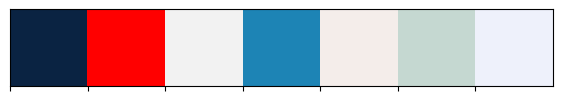

In [7]:
colors_dark = ["#0A2342", '#ff0000', '#f2f2f2', "#1d84b5" , '#f4edea', '#c5d8d1', '#eef1fb']

sns.palplot(colors_dark)

In [8]:
# Location of main Dataset
base_dir = 'C:\\Users\\Ananya saha\\Downloads\\BrainTumor_detection_CNN\\archive3\\Data'

In [9]:
# Loop over folders to extract class_names
classes = [class_name for class_name in os.listdir(base_dir)]
classes

['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']

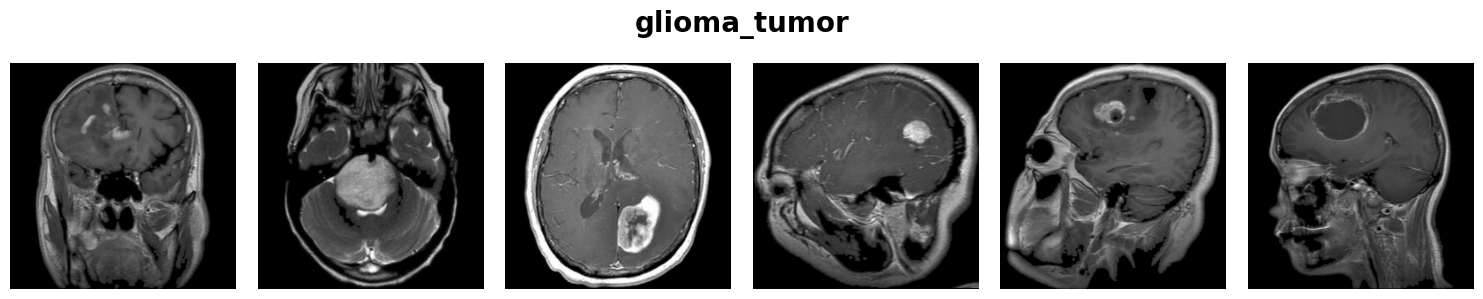

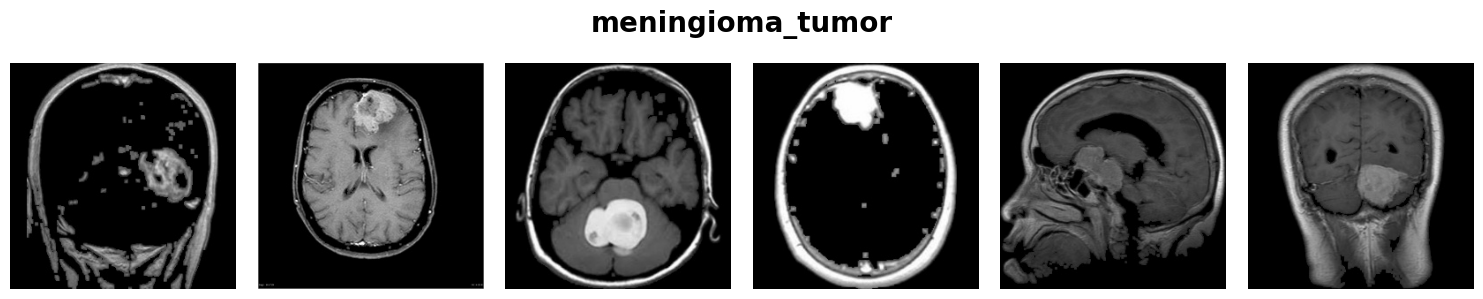

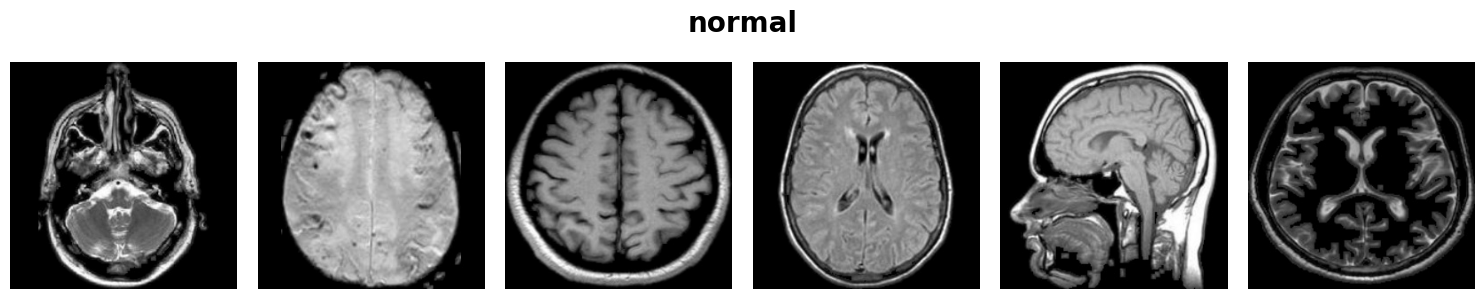

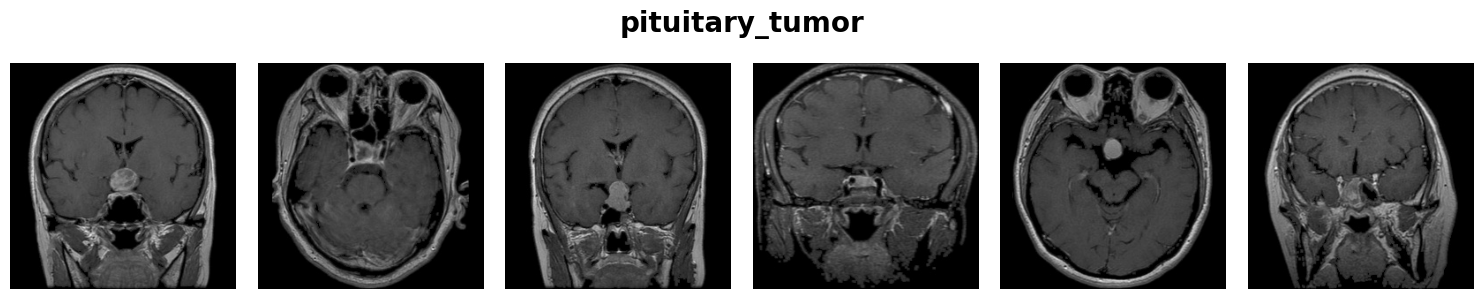

In [10]:
# A loop to iterate below codes for each class
for class_name in classes :
    # To create a plot with 1 row and 6 column
    fig, ax = plt.subplots(1, 6, figsize=(15, 3))
    # Define a variable for each class_name's path by joining base_directory and each class_name
    class_path = os.path.join(base_dir, class_name)
    # Files is a list of all image names in each folder (class)
    files = os.listdir(class_path)
    # Choose 6 random image from each class to show in plot
    random_images = random.choices(files, k=6)
    # A loop to iterate in each 6 random images
    for i in range(6) :
        # print class_name as suptitle for each class
        plt.suptitle(class_name, fontsize=20, fontweight='bold')
        # variable img is path of image, by joining class_path and image file name
        img = os.path.join(class_path ,random_images[i])
       # load image in img variable using keras.utils.load_img(image_path) 
        img = keras.utils.load_img(img)
        # Plot image
        ax[i].imshow(img)
        # Turn axis off
        ax[i].axis('off')
    # Make plots to become nearer to each other
    plt.tight_layout()

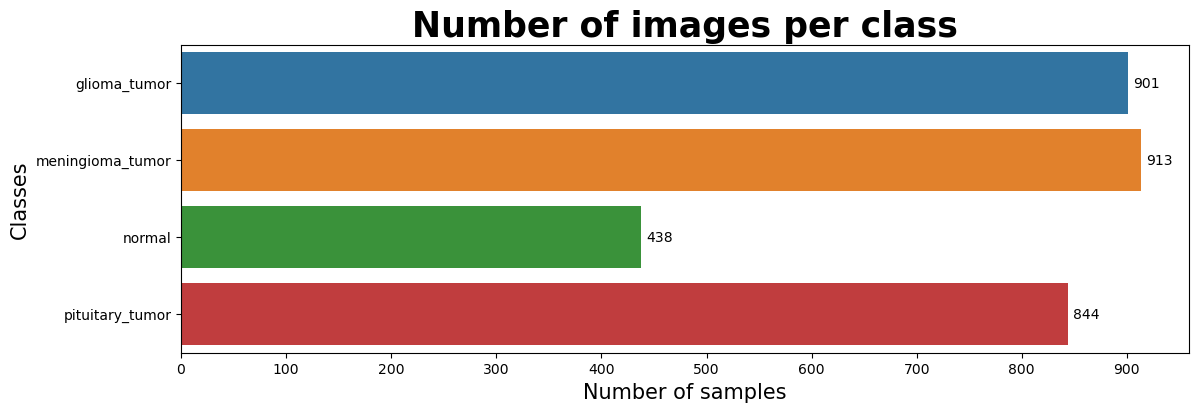

In [12]:
# Count is a list to store number of images for each class.
counts = [] 
# Loop over classes to iterate below code for each class
for class_name in classes :
    # Define class path by joining base_directory and class_name
    class_path = os.path.join(base_dir, class_name)
    # Add number of files in each class to count list
    counts.append(len(os.listdir(class_path)))

# Define plot size
plt.figure(figsize=(13, 4))
# Using seaborn to plot a barplot for each class
ax = sns.barplot(y=classes, x=counts)
# Set X-axis range and ticks
ax.set_xticks(range(0, 950, 100))
# Annotate each bar with the count
for i, p in enumerate(ax.patches):
    width = p.get_width()
    ax.text(width + 5, p.get_y() + p.get_height()/2., 
            '{}'.format(counts[i]),
            va="center", fontsize=10)
# Set plot title
plt.title('Number of images per class', fontsize=25, fontweight='bold')
# Set Y-axis label
plt.ylabel('Classes', fontsize=15)
# Set X-axis label
plt.xlabel('Number of samples', fontsize=15)
# Show plot
plt.show()

In [13]:
# Make sumation of all values in count list as all image counts.
sum_count_before = sum(counts)
print(colored(f'Number of all images is : {sum_count_before}', 'blue', attrs=['bold']))

Number of all images is : 3096


In [14]:
# Convert our data to tensorflow dataset by keras.utils.image_dataset_from_directory
train_full = keras.utils.image_dataset_from_directory(
    directory=base_dir,        # Path of base directory
    labels='inferred',         # to generate labels from the directory structure
    label_mode='categorical',  # type of labels
    class_names=classes,       # list of class_names
    shuffle=True,              # To shuffle dataset
    seed=42,                   # Optional random seed for shuffling and transformations
    batch_size=32,             # Define batch size
    image_size=(224, 224)      # Size to resize images to after they are read from disk
 )

Found 3096 files belonging to 4 classes.


In [15]:
# Shuffle dataset again after creation
train_full = train_full.shuffle(1024).prefetch(tf.data.AUTOTUNE)

In [16]:
# Print Number of all batches in dataset
num_of_full_train_batches = len(list(train_full))
print(colored(f'Number of batches in train_full : {num_of_full_train_batches}', 'black', attrs=['bold']))

Number of batches in train_full : 97


In [17]:
# Define variable to store number of batches for train dataset
num_train_batches = int(num_of_full_train_batches * 0.80)
# Define variable to store number of batches for validation and test dataset
num_valid_test_batches = num_of_full_train_batches - num_train_batches


# Print the TARGET : number of batches for train, validation and test dataset to each
print(colored(' Target : ', 'green', attrs=['bold']))
print('-'*35)
print(colored(f'Number of  Train  batches : {num_train_batches}', 'blue', attrs=['bold']))
print(colored(f'Number of Validation batches : {num_valid_test_batches//2}', 'blue', attrs=['bold']))
print(colored(f'Number of Test batches : {num_valid_test_batches//2}', 'blue', attrs=['bold']))

 Target : 
-----------------------------------
Number of  Train  batches : 77
Number of Validation batches : 10
Number of Test batches : 10


In [18]:
# Shuffle dataset
train_full = train_full.shuffle(buffer_size=3)

# Apply above settings to main dataset to split to train, validation and test dataset
train_ds = train_full.take(num_train_batches)
remain_ds = train_full.skip(num_train_batches)
valid_ds = remain_ds.take(num_valid_test_batches//2) 
test_ds = remain_ds.skip(num_valid_test_batches//2)

In [19]:
# Print number of batches in train, validation and test dataset after split them
print(colored(f'Number of train batches : {len(list(train_ds))}', 'green', attrs=['bold']))
print(colored(f'Number of valid batches : {len(list(valid_ds))}', 'green', attrs=['bold']))
print(colored(f'Number of test  batches : {len(list(test_ds))}', 'green', attrs=['bold']))

Number of train batches : 77
Number of valid batches : 10
Number of test  batches : 10


In [21]:
# Use ResNet50V2 from keras.application as pre trained model with imagenet weight
pre_trained_model = keras.applications.ResNet50V2(
    weights='imagenet', classes=4, input_shape=(224, 224, 3), include_top=False
)

In [22]:
pre_trained_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

 tchNormalization)                                                                                
                                                                                                  
 conv2_block3_preact_relu (  (None, 56, 56, 256)          0         ['conv2_block3_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16384     ['conv2_block3_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv3_block2_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block2_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block2_2_pad (ZeroPa  (None, 30, 30, 128)          0         ['conv3_block2_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block2_2_conv (Conv2  (None, 28, 28, 128)          147456    ['conv3_block2_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block2_2_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block2_2_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv3_block4_3_conv (Conv2  (None, 14, 14, 512)          66048     ['conv3_block4_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block4_out (Add)      (None, 14, 14, 512)          0         ['max_pooling2d_4[0][0]',     
                                                                     'conv3_block4_3_conv[0][0]'] 
                                                                                                  
 conv4_block1_preact_bn (Ba  (None, 14, 14, 512)          2048      ['conv3_block4_out[0][0]']    
 tchNormalization)                                                                                
                                                                                                  
 conv4_blo

 D)                                                                 0]']                          
                                                                                                  
 conv4_block3_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block3_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block3_2_pad (ZeroPa  (None, 16, 16, 256)          0         ['conv4_block3_1_relu[0][0]'] 
 dding2D)                                                                                         
          

 conv4_block5_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block5_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block5_3_conv (Conv2  (None, 14, 14, 1024)         263168    ['conv4_block5_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block5_out (Add)      (None, 14, 14, 1024)         0         ['conv4_block4_out[0][0]',    
                                                                     'conv4_block5_3_conv[0][0]'] 
                                                                                                  
 conv4_block6_preact_bn (Ba  (None, 14, 14, 1024)         4096      ['conv4_block5_out[0][0]']    
 tchNormal

                                                                                                  
 conv5_block2_preact_relu (  (None, 7, 7, 2048)           0         ['conv5_block2_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv5_block2_1_conv (Conv2  (None, 7, 7, 512)            1048576   ['conv5_block2_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv5_block2_1_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block2_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_blo

In [23]:
# Freeze all layers, except last layer
# The goal is to train just last layer of pre trained model

pre_trained_model.trainable = True               # Whole model is trainable
set_trainable = False                            # Set a flag to False

for layer in pre_trained_model.layers :          # A loop over model's layers
    if layer.name == 'conv5_block1_preact_bn' :  # Define target layer's name (with if condition)
        set_trainable = True                     # Change flag value to True
    if set_trainable :                           # A condition for True flag
        layer.trainable = True                   # Set layer trainablity to True
    else :                                       # else condition
        layer.trainable = False                  # For layers befor our target layer

In [24]:
# Add custom layers on top of the base model
model = keras.models.Sequential()
model.add(pre_trained_model)                           # At first add our pre-trained model
model.add(keras.layers.Dropout(0.5))                   # Use a Dropout layer to avoid over-fitting
model.add(keras.layers.GlobalAveragePooling2D())       # Apply GlobalAveragePooling2D
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024, activation='relu')) # Add a Dense layer with 1024 neuron with activation='relu'
model.add(keras.layers.Dropout(0.5))                   # Use a Dropout layer to avoid over-fitting
model.add(keras.layers.Dense(512, activation='relu'))  # Add a Dense layer with 512 neuron with activation='relu'
model.add(keras.layers.Dropout(0.5))                   # Use a Dropout layer to avoid over-fitting
model.add(keras.layers.Dense(4, activation='softmax')) # Add a Dense layer with number fo classes neuron as output with activation='softmax

In [25]:
model.build()

In [26]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
# Model CheckPoint Call-Back, to save best model parameters as a .keras file
checkpoint_cb = keras.callbacks.ModelCheckpoint('MyModel.keras', save_best_only=True) 

# Early Stoping Call-Backc to stop trainig process after 'patience' epochs if the metric doesn't grow
earlystop_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLROnPlateau Call-Back to decrease learning-rate base on 'monitor' parameter after 'patience' epochs with a 'factor' is doesn't improve
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
# Train model by .fit function
history = model.fit(
    train_ds,                                          # Dataset to train model
    epochs=75,                                        # Number of epochs to train
    validation_data=valid_ds,                          # Validation dataset
    #callbacks=[checkpoint_cb, earlystop_cb, reduce_lr] # List of call backs
)

Epoch 1/75
77/77 [==============================] - 342s 4s/step - loss: 1.1148 - accuracy: 0.5004 - val_loss: 1.7866 - val_accuracy: 0.2875
Epoch 2/75
77/77 [==============================] - 329s 4s/step - loss: 0.6809 - accuracy: 0.7342 - val_loss: 0.9331 - val_accuracy: 0.6859
Epoch 3/75
77/77 [==============================] - 307s 4s/step - loss: 0.4141 - accuracy: 0.8489 - val_loss: 0.2876 - val_accuracy: 0.8938
Epoch 4/75
77/77 [==============================] - 303s 4s/step - loss: 0.3116 - accuracy: 0.8925 - val_loss: 0.2016 - val_accuracy: 0.9156
Epoch 5/75
77/77 [==============================] - 295s 4s/step - loss: 0.2019 - accuracy: 0.9259 - val_loss: 0.0525 - val_accuracy: 0.9812
Epoch 6/75
77/77 [==============================] - 339s 4s/step - loss: 0.1683 - accuracy: 0.9412 - val_loss: 0.0370 - val_accuracy: 0.9875
Epoch 7/75
77/77 [==============================] - 378s 5s/step - loss: 0.1609 - accuracy: 0.9432 - val_loss: 0.0443 - val_accuracy: 0.9812
Epoch 8/75
77

In [ ]:
model.save_weights("mymodel1.h5")

In [ ]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)
# Show 5 tails of dataframe
result_df.tail()

In [ ]:
# Define a X variable to store range of epochs
x = np.arange(len(result_df))

# Create a plot with 3 row and 1 col with size of (15, 12)
fig, ax = plt.subplots(3, 1, figsize=(15, 12))

# AX0 : Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)                          
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].set_xticks(np.arange(0, len(x), 2))
ax[0].legend()

#  AX1 : Loss
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].set_xticks(np.arange(0, len(x), 2))
ax[1].legend()

#  AX2 : Loss
ax[2].plot(x, label='learning_rate', linewidth=2, marker='o')
ax[2].set_title('learning_rate', fontsize=20)
ax[2].set_xlabel('epochs')
ax[2].set_xticks(np.arange(0, len(x), 2))
ax[2].legend()

plt.show()

In [ ]:
#evaluation

In [ ]:
best_model = keras.models.load_model('MyModel.keras')

In [ ]:
# Evaluate model by model.evaluate()
loss, accuracy = best_model.evaluate(test_ds)
print()
print(colored(f'Loss : {loss}', 'green', attrs=['bold']))
print(colored(f'Accuracy : {accuracy*100}%', 'green', attrs=['bold']))

In [ ]:
# A function to load uploaded image, pre-processing and predict model
def predict_image(upload) :
    # Store a location in memory that image stored(with uploader)
    uploaded_content = list(upload.value)[0].content
    # Load image from memory to img variable by io.BytesIO and PIL.Image
    img = Image.open(io.BytesIO(uploaded_content))
    # Load image by cv2
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    # Resize image to (224, 224) whitch is ResNet50V2 input size
    img = cv2.resize(opencvImage,(224,224))
    # Reshape image array to add 3 channels
    img = img.reshape(1,224,224,3)
    # Predict model with best_model
    p = best_model.predict(img)
    # Return high probability of predictions
    p = np.argmax(p,axis=1)[0]
    
    
    if p==0:
        print('The model predicts that there is no tumor')
        
    elif p==1:
        p='Pituitary Tumor'
        
    elif p==2:
        p='Meningioma Tumor'
        
    if p==3:
        p='Glioma Tumor'
    
    if p!=0:
        print()
        print(colored(f'The Model predicts that it is a {p}', 'green'))

In [ ]:
# Create Upload button by ipywidget

upload = ipywidgets.FileUpload(accept='.jpg', multiple=False)
display(upload)

In [ ]:
button = ipywidgets.Button(description='Predict')
out = ipywidgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            predict_image(upload)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
ipywidgets.VBox([button,out])